# Project Assignment: Short Video Recommender System (KuaiRec)

## Objective
Design and implement a recommender system that provides personalized short video suggestions to users by leveraging their preferences, interaction history, and video content from the KuaiRec dataset. The goal is to build a scalable recommendation engine akin to those powering platforms such as TikTok or Kuaishou.

### Install the Dataset

In [1]:
%%bash
wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE&export=download&confirm=t&uuid=b2002093-cc6e-4bd5-be47-9603f0b33470
' -O KuaiRec.zip
unzip KuaiRec.zip -d data_final_project
mv "data_final_project/KuaiRec 2.0" data_final_project/KuaiRec

--2025-05-17 09:29:45--  https://drive.usercontent.google.com/download?id=1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE&export=download&confirm=t&uuid=b2002093-cc6e-4bd5-be47-9603f0b33470%0A
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 216.58.213.65, 2a00:1450:4007:806::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|216.58.213.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 431964858 (412M) [application/octet-stream]
Saving to: ‘KuaiRec.zip’

     0K .......... .......... .......... .......... ..........  0% 6.42M 64s
    50K .......... .......... .......... .......... ..........  0% 8.45M 56s
   100K .......... .......... .......... .......... ..........  0% 9.29M 52s
   150K .......... .......... .......... .......... ..........  0% 19.3M 45s
   200K .......... .......... .......... .......... ..........  0% 7.21M 47s
   250K .......... .......... .......... .......... ..........  0% 7.54M 48s
   300K ......

Archive:  KuaiRec.zip
   creating: data_final_project/KuaiRec 2.0/
  inflating: data_final_project/KuaiRec 2.0/LICENSE  
  inflating: data_final_project/KuaiRec 2.0/Statistics_KuaiRec.ipynb  
   creating: data_final_project/KuaiRec 2.0/data/
  inflating: data_final_project/KuaiRec 2.0/data/big_matrix.csv  
  inflating: data_final_project/KuaiRec 2.0/data/item_categories.csv  
  inflating: data_final_project/KuaiRec 2.0/data/item_daily_features.csv  
  inflating: data_final_project/KuaiRec 2.0/data/kuairec_caption_category.csv  
  inflating: data_final_project/KuaiRec 2.0/data/small_matrix.csv  
  inflating: data_final_project/KuaiRec 2.0/data/social_network.csv  
  inflating: data_final_project/KuaiRec 2.0/data/user_features.csv  
   creating: data_final_project/KuaiRec 2.0/figs/
  inflating: data_final_project/KuaiRec 2.0/figs/KuaiRec.png  
  inflating: data_final_project/KuaiRec 2.0/figs/colab-badge.svg  
  inflating: data_final_project/KuaiRec 2.0/loaddata.py  


### Install Dependencies

In [2]:
!pip install pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Importing Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load the Dataset

In [2]:
train_dataset = pd.read_csv("data_final_project/KuaiRec/data/big_matrix.csv")
test_dataset = pd.read_csv("data_final_project/KuaiRec/data/small_matrix.csv")

In [3]:
train_dataset.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


### Preprocess the Data

In [4]:
# drop the columns that are not needed
train_dataset.dropna(inplace=True)
train_dataset.drop_duplicates(inplace=True)

In [5]:
# under the limit threshold, the videos are considered not relevant
limit = 1000

# keep only the videos that have at least x interactions
video_ids_to_keep = (
    train_dataset.groupby("video_id").size().sort_values(ascending=False) >= limit
)
video_ids_to_keep = video_ids_to_keep[video_ids_to_keep]
train_set_filtered = train_dataset[train_dataset["video_id"].isin(video_ids_to_keep.index)]

(0.0, 5.0)

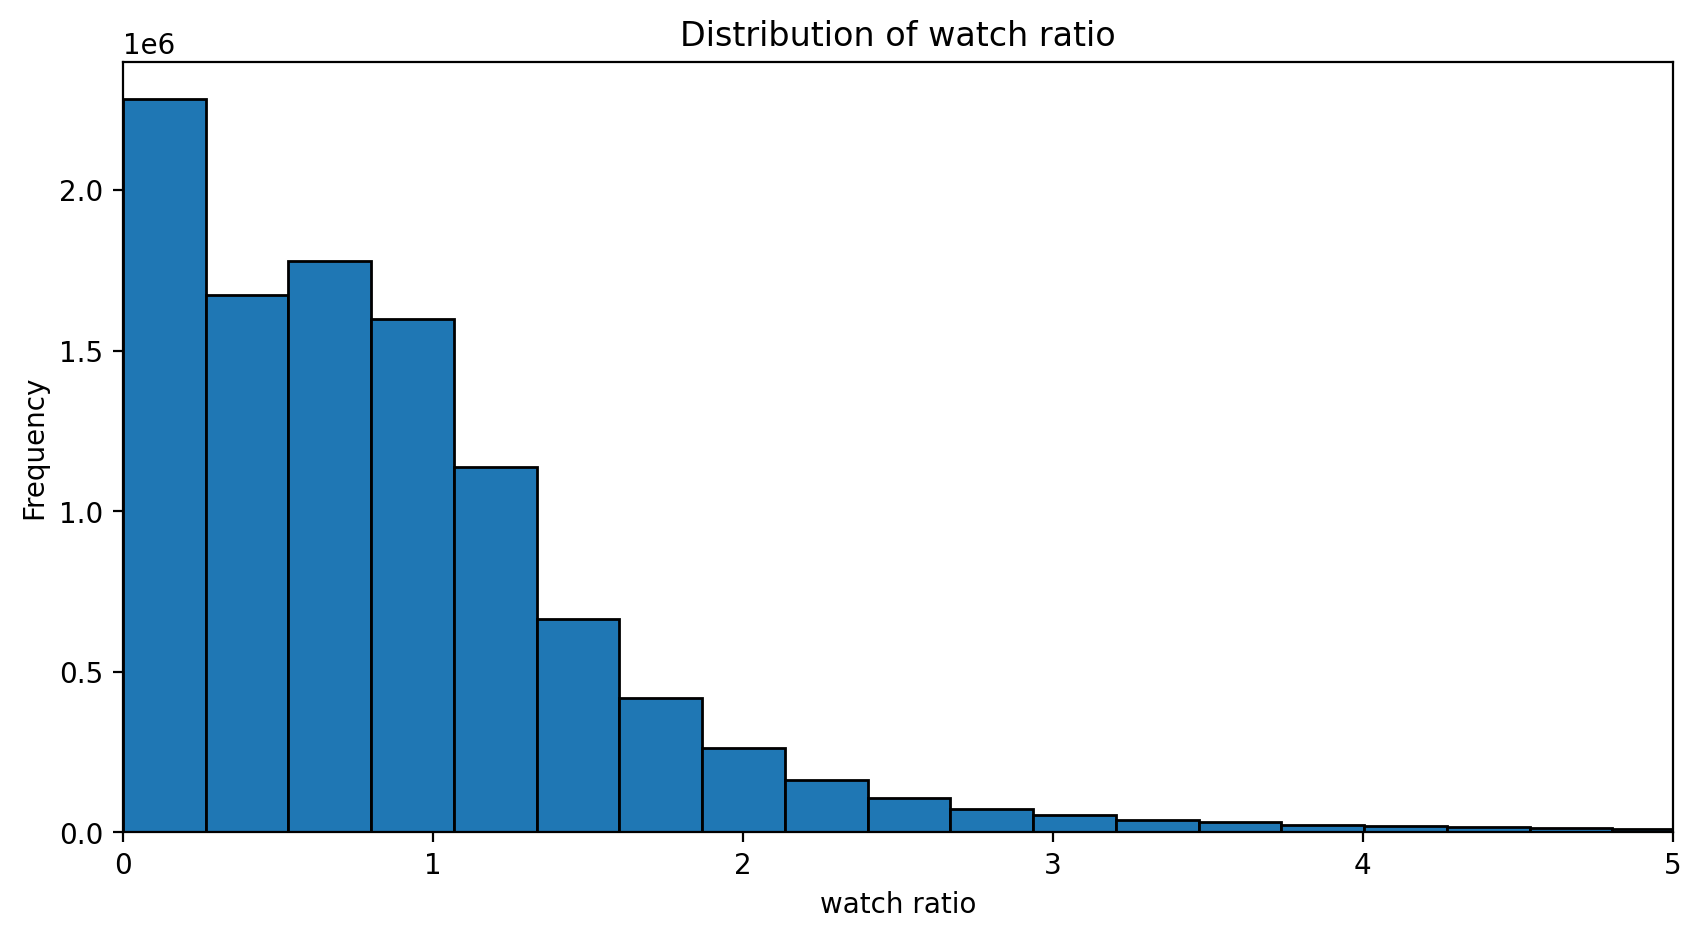

In [6]:
# Plot the distribution of watch_ratio
plt.figure(figsize=(10, 5))
plt.hist(train_set_filtered["watch_ratio"], bins=1000, edgecolor="black")
plt.title("Distribution of watch ratio")
plt.xlabel("watch ratio")
plt.ylabel("Frequency")
plt.xlim(0, 5)

/tmp/ipykernel_23962/487437425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_filtered["watch_ratio"] = train_set_filtered.loc[:, "watch_ratio"].apply(


Text(0, 0.5, 'Frequency')

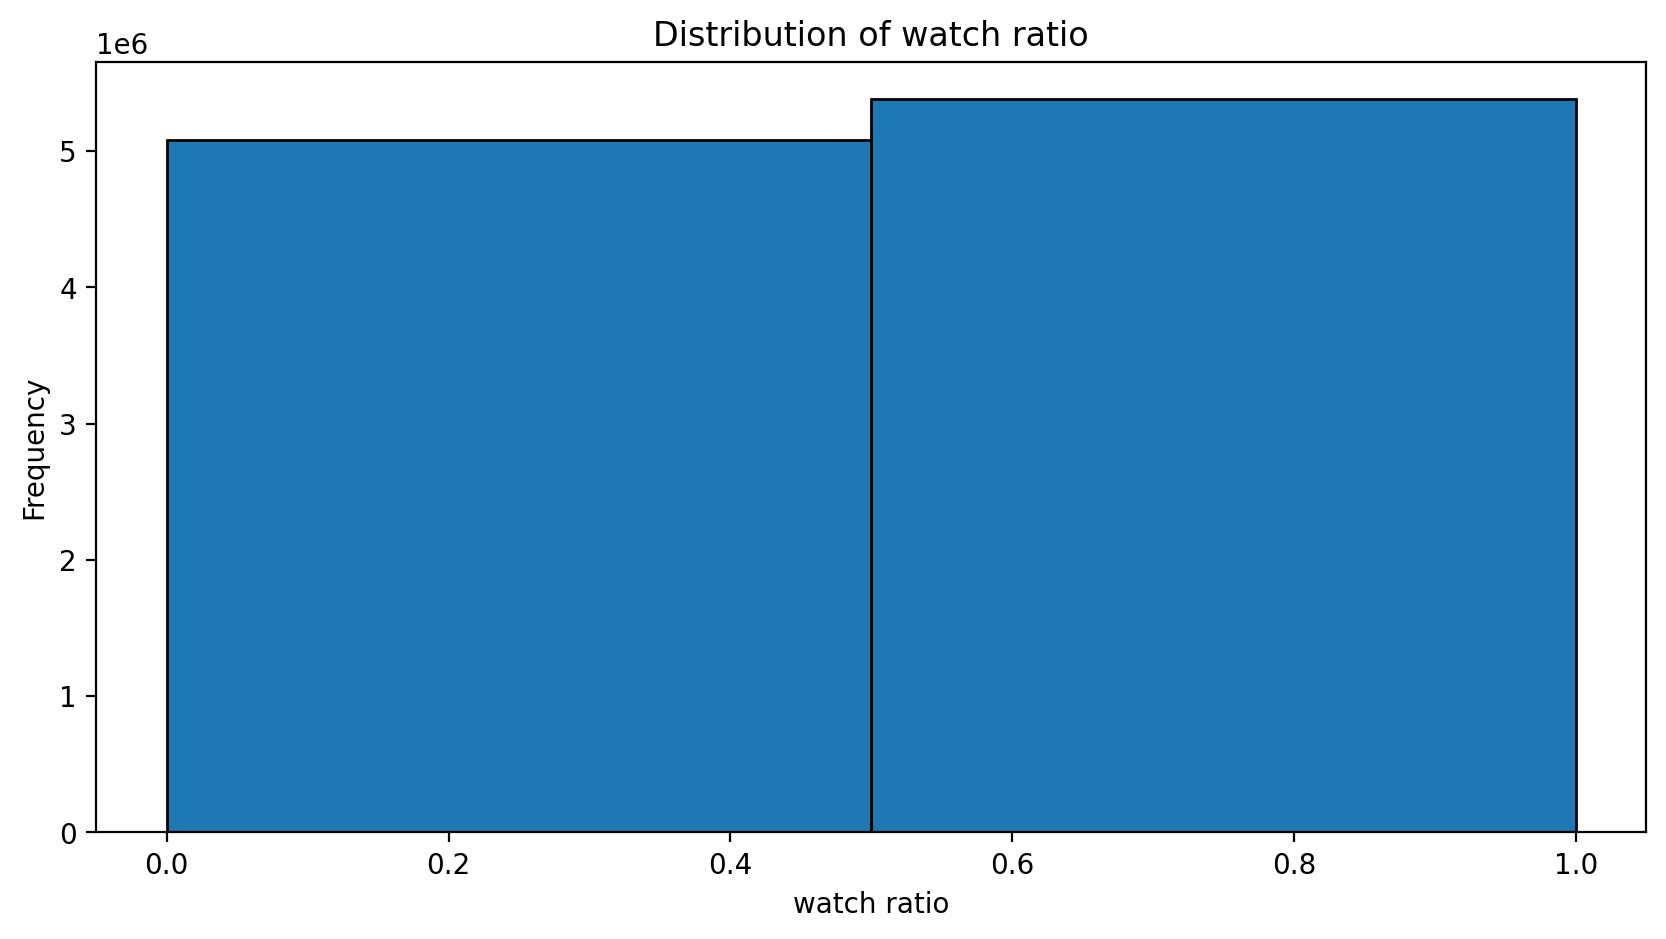

In [7]:
# the limit is the threshold to consider a watch ratio as relevant
# we can set the limit to 0.7, which means that the user watched at least 70% of the video
limit = 0.7

train_set_filtered["watch_ratio"] = train_set_filtered.loc[:, "watch_ratio"].apply(
    lambda x: 0 if x < limit else 1
)
plt.figure(figsize=(10, 5))
plt.hist(train_set_filtered.loc[:, "watch_ratio"], bins=2, edgecolor="black")
plt.title("Distribution of watch ratio")
plt.xlabel("watch ratio")
plt.ylabel("Frequency")

In [8]:
# Pivot the filtered training set to create a user-item interaction matrix,
# where rows are user_ids, columns are video_ids, and values are watch_ratio
train_set_filtered = train_set_filtered.pivot_table(
    index="user_id", columns="video_id", values="watch_ratio"
)
# Fill NaN values with -1
train_set_filtered = train_set_filtered.fillna(-1)
train_set_filtered.head()

video_id,48,50,63,66,67,70,71,72,80,82,...,10500,10506,10519,10552,10568,10572,10589,10595,10640,10663
user_id,,,,,,,,,,,,,,,,,,,,,
0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,1.0,1.0,1.0,0.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.5,1.0,1.0,0.0,-1.0,-1.0,1.0,1.0,0.0,0.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
3,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [9]:
kuairec_caption_category = pd.read_csv("data_final_project/KuaiRec/data/kuairec_caption_category.csv", engine="python")

In [10]:
# drop the columns that are not needed
kuairec_caption_category.dropna(inplace=True)
kuairec_caption_category.drop_duplicates(inplace=True)
kuairec_caption_category.drop(columns=["manual_cover_text", "first_level_category_id", "first_level_category_name", "second_level_category_id", "second_level_category_name", "third_level_category_id", "third_level_category_name"], inplace=True)

In [11]:
kuairec_caption_category.head()

,video_id,caption,topic_tag
0,0,精神小伙路难走 程哥你狗粮慢点撒,[]
2,2,晚饭后，运动一下！,[]
3,3,我平淡无奇，惊艳不了时光，温柔不了岁月，我只想漫无目的的走走，努力发笔小财，给自己买花 自己长大.,[]
4,4,#搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,"[五爱市场,感谢快手我要上热门,搞笑]"
5,5,“你们吵的越狠 他们的手就握的越紧” #文轩 #刘耀文 #宋亚轩 #顾子璇...,"[刘耀文,宋亚轩,文轩,顾子璇是樱桃吖,顾子璇超级喜欢文轩]"


In [12]:
# Filter kuairec_caption_category to only include videos present in train_set_filtered columns
kuairec_caption_category_filtered = kuairec_caption_category[kuairec_caption_category["video_id"].astype("int64").isin(train_set_filtered.columns)]
len(kuairec_caption_category_filtered)

3562

In [13]:
kuairec_caption_category_filtered.head()

,video_id,caption,topic_tag
48,48,感谢双击，有喜欢的告诉我你们在哪里呢,[]
50,50,#今天拍点啥 #蝴蝶结 #支持快手传播正能量 #感谢官方大大给的每一次热门 #一人一首周杰伦,"[一人一首周杰伦,今天拍点啥,感谢官方大大给的每一次热门,支持快手传播正能量,蝴蝶结]"
63,63,不会是你女友,[]
66,66,心之所想才是心之所向＃感谢官方大大给的热门. #父母的小小心愿 #请允许我自恋一下,"[感谢官方大大给的热门,父母的小小心愿,请允许我自恋一下]"
67,67,上火惹无语,[]


## Content-based filtering

In [14]:
# Compute TF-IDF features for the 'caption' column of the filtered video metadata
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(kuairec_caption_category_filtered["caption"])
tfidf_matrix.shape

(3562, 1000)

In [15]:
# One-hot encode the video_id column for the filtered video metadata
onehot = OneHotEncoder()
onehot_matrix = onehot.fit_transform(kuairec_caption_category_filtered[["video_id"]])
onehot_matrix.shape

(3562, 3562)

In [16]:
video_vectors = np.concatenate(
    [
        tfidf_matrix.toarray(),
        onehot_matrix.toarray(),
    ],
    axis=1,
)

In [17]:
# Compute the cosine similarity matrix for the video vectors
cosine_matrix = cosine_similarity(video_vectors)

In [18]:
kuairec_caption_category_filtered.head()

,video_id,caption,topic_tag
48,48,感谢双击，有喜欢的告诉我你们在哪里呢,[]
50,50,#今天拍点啥 #蝴蝶结 #支持快手传播正能量 #感谢官方大大给的每一次热门 #一人一首周杰伦,"[一人一首周杰伦,今天拍点啥,感谢官方大大给的每一次热门,支持快手传播正能量,蝴蝶结]"
63,63,不会是你女友,[]
66,66,心之所想才是心之所向＃感谢官方大大给的热门. #父母的小小心愿 #请允许我自恋一下,"[感谢官方大大给的热门,父母的小小心愿,请允许我自恋一下]"
67,67,上火惹无语,[]


In [30]:
def recommend_videos(video_id, user_id, cosine_matrix, df_videos, k):
    """
    Recommend k videos similar to the given video_id that the user has not seen yet.
    :param video_id: The ID of the video to find similar videos for.
    :param user_id: The ID of the user to filter out seen videos.
    :param cosine_matrix: The cosine similarity matrix for the videos.
    :param df_videos: The DataFrame containing video metadata.
    :param k: The number of similar videos to recommend.
    :return: A DataFrame containing the recommended videos.
    """
    # Get the index of the video
    try:
        # Ensure video_id is int for matching, but do not overwrite the DataFrame column
        video_id_int = int(video_id)
        video_index = df_videos.index[df_videos["video_id"] == video_id][0]
    except IndexError:
        print("Video ID not found.")
        return None
    # Get the cosine similarity between the video and all other videos
    if len(cosine_matrix) <= video_index:
        print("Video index out of range.")
        return None
    cosine_similarity_scores = cosine_matrix[video_index]
    # Exclude the video itself
    similar_indices = cosine_similarity_scores.argsort()[::-1]
    similar_indices = [i for i in similar_indices if i != video_index]
    # Exclude videos already seen by the user
    if user_id in train_set_filtered.index:
        seen_video_ids = set(train_set_filtered.columns[(train_set_filtered.loc[user_id] != -1)])
    else:
        seen_video_ids = set()
    unseen_indices = [i for i in similar_indices if df_videos.iloc[i]["video_id"] not in seen_video_ids]
    # Return top-k unseen videos
    return df_videos.iloc[unseen_indices[:k]]

In [31]:
test_dataset["video_id"] = test_dataset["video_id"].astype(int)

def precision_at_k(recommend_func, test_df, k=5):
    """
    Calculate the precision at k for the recommendation function.
    :param recommend_func: The recommendation function to evaluate.
    :param test_df: The DataFrame containing the test set.
    :param k: The number of recommendations to consider.
    :return: The precision at k.
    """
    hits = 0
    total = 0
    for idx, row in test_df.iterrows():
        video_id = row["video_id"]
        user_id = row["user_id"]
        # Get top-k recommendations for this video
        recs = recommend_func(video_id, user_id, cosine_matrix, kuairec_caption_category_filtered, k)
        if recs is not None:
            recommended_ids = recs["video_id"].astype(int).tolist()
            # Check if any recommended video was actually watched by the user in test set
            user_watched = test_df[(test_df["user_id"] == user_id)]["video_id"].tolist()
            hits += len(set(recommended_ids) & set(user_watched))
        total += k
        if idx > 10000:
            break
    return hits / total if total > 0 else 0

precision = precision_at_k(recommend_videos, test_dataset, k=10)
print(f"Precision@10: {precision:.4f}")

Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video ID not

In [32]:
def recall_at_k(recommend_func, test_df, k=5):
    """
    Calculate the recall at k for the recommendation function.
    :param recommend_func: The recommendation function to evaluate.
    :param test_df: The DataFrame containing the test set.
    :param k: The number of recommendations to consider.
    :return: The recall at k.
    """
    hits = 0
    total = 0
    for idx, row in test_df.iterrows():
        video_id = row["video_id"]
        user_id = row["user_id"]
        recs = recommend_func(video_id, user_id, cosine_matrix, kuairec_caption_category_filtered, k)
        if recs is not None:
            recommended_ids = recs["video_id"].astype(int).tolist()
            user_watched = test_df[test_df["user_id"] == user_id]["video_id"].tolist()
            relevant = set(user_watched)
            retrieved = set(recommended_ids)
            if relevant:
                hits += len(retrieved & relevant)
                total += len(relevant)
        if idx > 10000:
            break
    return hits / total if total > 0 else 0

recall = recall_at_k(recommend_videos, test_dataset, k=10)
print(f"Recall@10: {recall:.4f}")

Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video ID not

In [33]:
from sklearn.metrics import ndcg_score

def ndcg_at_k(recommend_func, test_df, k=5):
    """
    Calculate the NDCG at k for the recommendation function.
    :param recommend_func: The recommendation function to evaluate.
    :param test_df: The DataFrame containing the test set.
    :param k: The number of recommendations to consider.
    :return: The NDCG at k.
    """
    ndcg_scores = []
    for idx, row in test_df.iterrows():
        video_id = row["video_id"]
        user_id = row["user_id"]
        recs = recommend_func(video_id, user_id, cosine_matrix, kuairec_caption_category_filtered, 5)
        if recs is not None:
            recommended_ids = recs["video_id"].astype(int).tolist()
            # Relevance: 1 if user watched, 0 otherwise
            user_watched = test_df[test_df["user_id"] == user_id]["video_id"].tolist()
            relevance = [1 if vid in user_watched else 0 for vid in recommended_ids]
            # ndcg_score expects arrays of shape (1, n_labels)
            ndcg = ndcg_score([relevance], [relevance], k=k)
            ndcg_scores.append(ndcg)
        if idx > 10000:  # Limit for speed
            break
    return np.mean(ndcg_scores) if ndcg_scores else 0

ndcg = ndcg_at_k(recommend_videos, test_dataset, k=10)
print(f"NDCG@{10}: {ndcg:.4f}")

Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video index out of range.
Video ID not

# Collaborative filtering